# ASHRAE – Great Energy Predictor III  
## Polynomial ElasticNet Baseline by Ziad B.
This notebook trains a LightGBM regressor and generates hourly prediction.


---
## 1  Import Dependencies

In [1]:
import numpy as np, pandas as pd, os, joblib, lightgbm as lgb
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split
from lightgbm import early_stopping, log_evaluation
import matplotlib.pyplot as plt, seaborn as sns

## 2  Load and Merge Data

In [2]:
data_path = "../data_kaggle/"
os.makedirs("../outputs", exist_ok=True)
np.random.seed(42)

train = pd.read_csv(data_path + "train.csv")
test  = pd.read_csv(data_path + "test.csv")
building = pd.read_csv(data_path + "building_metadata.csv")
weather_tr = pd.read_csv(data_path + "weather_train.csv")
weather_te = pd.read_csv(data_path + "weather_test.csv")

# Keep electricity only
train = train[train["meter"] == 0]
print("Train:", train.shape, "Test:", test.shape)

Train: (12060910, 4) Test: (41697600, 4)


In [3]:
def merge_weather(df, weather):
    df = df.merge(building, on="building_id", how="left")
    df = df.merge(weather, on=["site_id","timestamp"], how="left")
    return df

train_full = merge_weather(train, weather_tr)
test_full  = merge_weather(test,  weather_te)

## 3  Feature Engineering & Cleaning

In [4]:
for df in [train_full, test_full]:
    df["timestamp"]   = pd.to_datetime(df["timestamp"])
    df["month"]       = df["timestamp"].dt.month
    df["day_of_week"] = df["timestamp"].dt.dayofweek
    df["hour"]        = df["timestamp"].dt.hour
    df["is_weekend"]  = df["day_of_week"].isin([5,6]).astype(int)

## 5  Feature Lists and Preprocessor

In [5]:
def clean_numeric(df):
    cols = ["air_temperature","dew_temperature","wind_speed",
            "cloud_coverage","precip_depth_1_hr","sea_level_pressure"]
    df[cols] = df[cols].replace([np.inf,-np.inf], np.nan)
    df["precip_depth_1_hr"] = df["precip_depth_1_hr"].clip(lower=0)
    df["air_temperature"]   = df["air_temperature"].clip(-50,60)
    df["dew_temperature"]   = df["dew_temperature"].clip(-50,60)
    df["sea_level_pressure"]= df["sea_level_pressure"].clip(800,1100)
    df["wind_speed"]        = df["wind_speed"].clip(0,100)
    df["cloud_coverage"]    = df["cloud_coverage"].clip(0,10)
    for c in cols:
        df[c] = df[c].fillna(df[c].median())
    return df

train_full = clean_numeric(train_full)
test_full  = clean_numeric(test_full)

In [6]:
# Log/Box‑Cox style transform for scale-heavy features
scale_features = ["square_feet","year_built","floor_count"]
pt = PowerTransformer(method="yeo-johnson", standardize=True)
train_full[scale_features] = pt.fit_transform(train_full[scale_features])
test_full[scale_features]  = pt.transform(test_full[scale_features])

# Still keep log(SF) variant for non‑linearity
train_full["log_sqft"] = np.log1p(np.expm1(train_full["square_feet"]))
test_full["log_sqft"]  = np.log1p(np.expm1(test_full["square_feet"]))

In [7]:
num_features = ["square_feet","year_built","floor_count",
                "air_temperature","dew_temperature","wind_speed",
                "cloud_coverage","precip_depth_1_hr","sea_level_pressure",
                "month","day_of_week","hour","is_weekend","log_sqft"]
cat_features = ["primary_use","site_id"]

for df in [train_full, test_full]:
    for c in cat_features: df[c] = df[c].astype("category")

target = np.log1p(train_full["meter_reading"].clip(lower=0))
features = num_features + cat_features

## 6  Train Final Model (using Cleaned Training Data)

In [8]:
train_ds, val_ds = train_test_split(train_full, test_size=0.1, random_state=42)
y_train = np.log1p(train_ds["meter_reading"].clip(lower=0))
y_val   = np.log1p(val_ds["meter_reading"].clip(lower=0))

train_lgb = lgb.Dataset(train_ds[features], label=y_train,
                        categorical_feature=cat_features, free_raw_data=False)
val_lgb   = lgb.Dataset(val_ds[features], label=y_val,
                        categorical_feature=cat_features, reference=train_lgb)

In [9]:
# =====================================================
#  LightGBM Parameters (Regularization incorporated)
# =====================================================
params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,        # can tune 0.02‑0.1
    "num_leaves": 128,            # depth/complexity control (regularization)
    "feature_fraction": 0.8,      # column subsampling
    "bagging_fraction": 0.8,      # row subsampling
    "bagging_freq": 5,            # perform bagging every 5 trees
    "lambda_l1": 0.2,             # L1 regularization (keep elasticnet spirit)
    "lambda_l2": 0.4,             # L2 regularization
    "min_data_in_leaf": 50,       # prevents over‑fitting on small splits
    "boosting": "gbdt",
    "seed": 42,
    "verbosity": -1
}

In [10]:
# =====================================================
# Train Model (with validation)
# =====================================================
print("Training LightGBM model ...")
callbacks = [
    early_stopping(stopping_rounds=100),
    log_evaluation(period=50)      # prints every 50 iterations
]

model = lgb.train(
    params,
    train_lgb,
    num_boost_round=1500,
    valid_sets=[train_lgb, val_lgb],
    valid_names=["train", "val"],
    callbacks=callbacks
)

joblib.dump(model, "../outputs/lightgbm_full_refined.pkl")
print("Model trained & saved — best_iteration:", model.best_iteration)

Training LightGBM model ...
Training until validation scores don't improve for 100 rounds
[50]	train's rmse: 0.759574	val's rmse: 0.760661
[100]	train's rmse: 0.65243	val's rmse: 0.653143
[150]	train's rmse: 0.597405	val's rmse: 0.598254
[200]	train's rmse: 0.562878	val's rmse: 0.563695
[250]	train's rmse: 0.534272	val's rmse: 0.535216
[300]	train's rmse: 0.512555	val's rmse: 0.513601
[350]	train's rmse: 0.495426	val's rmse: 0.496496
[400]	train's rmse: 0.483241	val's rmse: 0.484367
[450]	train's rmse: 0.472553	val's rmse: 0.473766
[500]	train's rmse: 0.462749	val's rmse: 0.46403
[550]	train's rmse: 0.45416	val's rmse: 0.455558
[600]	train's rmse: 0.447134	val's rmse: 0.448645
[650]	train's rmse: 0.439205	val's rmse: 0.440924
[700]	train's rmse: 0.432097	val's rmse: 0.433965
[750]	train's rmse: 0.426723	val's rmse: 0.428741
[800]	train's rmse: 0.421704	val's rmse: 0.423832
[850]	train's rmse: 0.41625	val's rmse: 0.418549
[900]	train's rmse: 0.411197	val's rmse: 0.413671
[950]	train's r

<Figure size 1000x800 with 0 Axes>

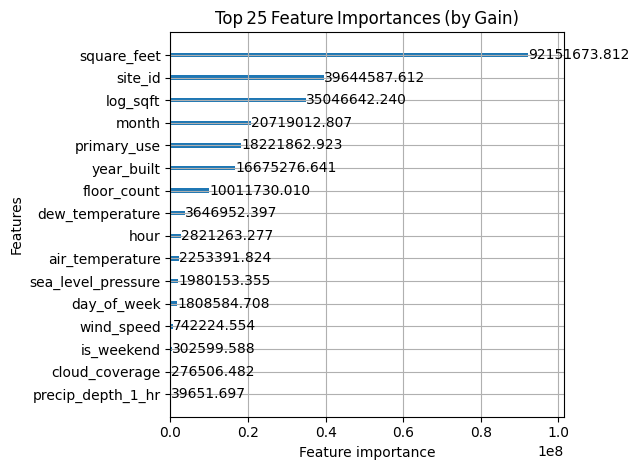

In [11]:
# =====================================================
#  Feature Importance Plot
# =====================================================
plt.figure(figsize=(10,8))
lgb.plot_importance(model, max_num_features=25, importance_type="gain")
plt.title("Top 25 Feature Importances (by Gain)")
plt.tight_layout()
plt.show()

## 7  Inference on Kaggle Test Set & Submission

In [12]:
features = num_features + cat_features
print("Predicting on full hourly test ...")
pred_log = model.predict(test_full[features], num_iteration=model.best_iteration)
pred = np.expm1(pred_log).clip(0, None)

submission = pd.DataFrame({
    "row_id": test_full["row_id"],
    "meter_reading": pred
})
submission.to_csv("../outputs/submission_refined_lgb.csv", index=False)
print(" Submission file saved:", submission.shape)

Predicting on full hourly test ...
 Submission file saved: (41697600, 2)


In [13]:
print("Best iteration:", model.best_iteration)
print("Best val RMSE:", model.best_score['val']['rmse'])

Best iteration: 1500
Best val RMSE: 0.38199635892403627


In [16]:
# A: with both
rmse_both = model.best_score['val']['rmse']

# B: only log_sqft
features_no_sf = [f for f in features if f != 'square_feet']
train_lgb_no_sf = lgb.Dataset(train_full[features_no_sf], label=target,
                              categorical_feature=cat_features)
# compute a manual training RMSE if it wasn't logged
preds_no_sf = model_no_sf.predict(train_full[features_no_sf],
                                  num_iteration=model_no_sf.best_iteration)
y_true      = np.expm1(target)                    # revert log1p(target)
rmse_no_sf  = np.sqrt(((np.expm1(preds_no_sf) - y_true) ** 2).mean())

print("RMSE both (log‑scale):", model.best_score.get("val", {}).get("rmse"))
print("Manual RMSE only log_sqft (kWh scale):", rmse_no_sf)

RMSE both (log‑scale): 0.38199635892403627
Manual RMSE only log_sqft (kWh scale): 97.59787752302177
